In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv("C:/Users/hym97/신용카드/train.csv")
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 

test = pd.read_csv("C:/Users/hym97/신용카드/test.csv")
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('C:/Users/hym97/신용카드/sample_submission.csv')

In [5]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NAN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [6]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NAN,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [7]:
test['occyp_type'].value_counts()

NAN                      3152
Laborers                 1699
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [10]:
test['DAYS_EMPLOYED'].describe()

count     10000.000000
mean      59776.690400
std      138121.224504
min      -15661.000000
25%       -3153.000000
50%       -1577.000000
75%        -410.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [6]:
train.shape

(26457, 19)

In [7]:
test.shape

(10000, 18)

In [8]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     26457 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

Column 종류
* gender(성별) : M/F
* car(차량 소유 여부) : Y/N
* reality(부동산 소유 여부) : Y/N
* child_num(자녀 수) : 연속적인 데이터, 19라는 max값은 처리해줘야함
* income_total(연간소득)
* income_type(소득유형) : categorical - [Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
* edu_type(교육유형) : categorical - ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
* family_type(결혼여부) : categorical - ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
* house_type(생활방식) : categoricla - ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']
* DAYS_BIRTH: 출생일
* DAYS_EMPLOYED: 업무 시작일
* FLAG_MOBIL: 핸드폰 소유 여부
* work_phone: 업무용 전화 소유 여부
* phone: 전화 소유 여부
* email: 이메일 소유 여부
* occyp_type: 직업 유형
* family_size: 가족 규모
* begin_month: 신용카드 발급 월

* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

# EDA

1. gender

In [10]:
train['gender'].value_counts()

F    17697
M     8760
Name: gender, dtype: int64

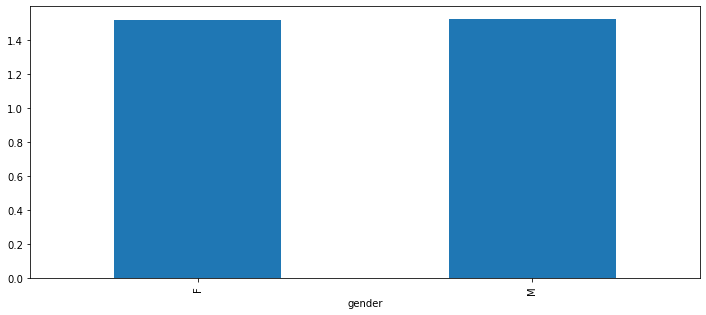

In [11]:
train.groupby('gender')['credit'].mean().sort_values().plot(kind='bar',figsize=(12,5))

남녀 상관없이 credit값의 평균은 비슷함



2. car

In [12]:
train['car'].value_counts()

N    16410
Y    10047
Name: car, dtype: int64

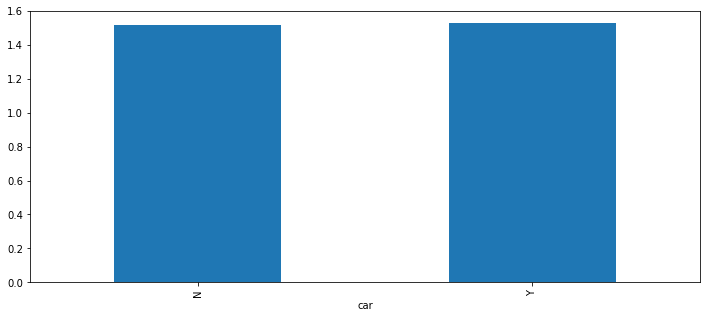

In [13]:
train.groupby('car')['credit'].mean().sort_values().plot(kind='bar', figsize=(12,5))

차 소유 여부 역시 credit값의 평균은 비슷함

3. reality

In [14]:
train['reality'].value_counts()

Y    17830
N     8627
Name: reality, dtype: int64

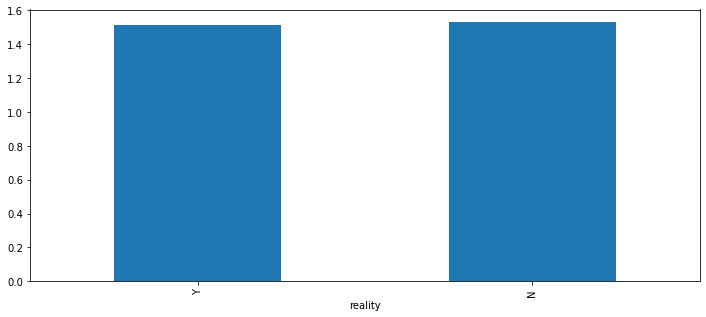

In [15]:
train.groupby('reality')['credit'].mean().sort_values().plot(kind='bar', figsize=(12,5))

4.child_num

In [16]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

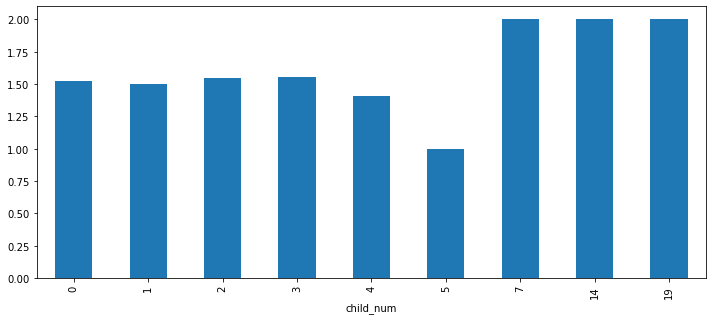

In [17]:
train.groupby('child_num')['credit'].mean().plot(kind='bar', figsize=(12,5))

5. income_total

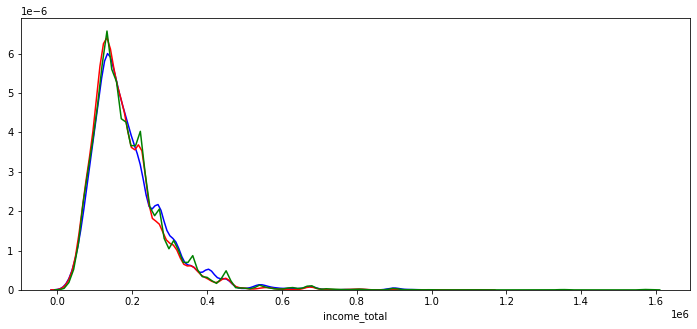

In [18]:
df1 = train.loc[train['credit']==0, 'income_total']
df2 = train.loc[train['credit']==1, 'income_total']
df3 = train.loc[train['credit']==2, 'income_total']

plt.figure(figsize = (12,5))
sns.distplot(df1, kde=True, rug=False, hist=False, color = 'blue')
sns.distplot(df2, kde=True, rug=False, hist=False, color = 'red')
sns.distplot(df3, kde=True, rug=False, hist=False, color = 'green')

6. income_type

In [19]:
train['income_type'].value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

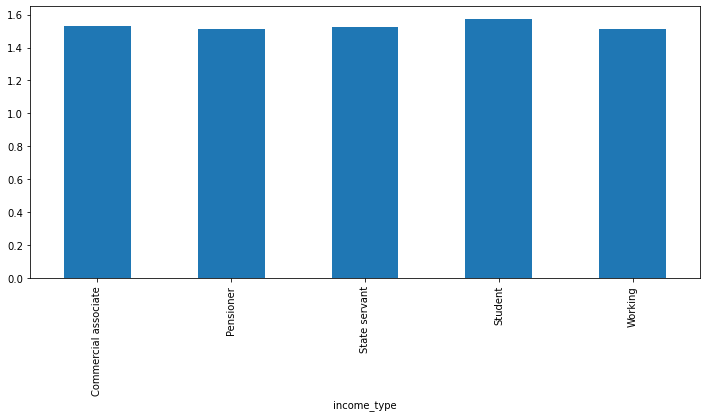

In [20]:
train.groupby('income_type')['credit'].mean().plot(kind='bar', figsize=(12,5))

7. edu_type

In [21]:
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

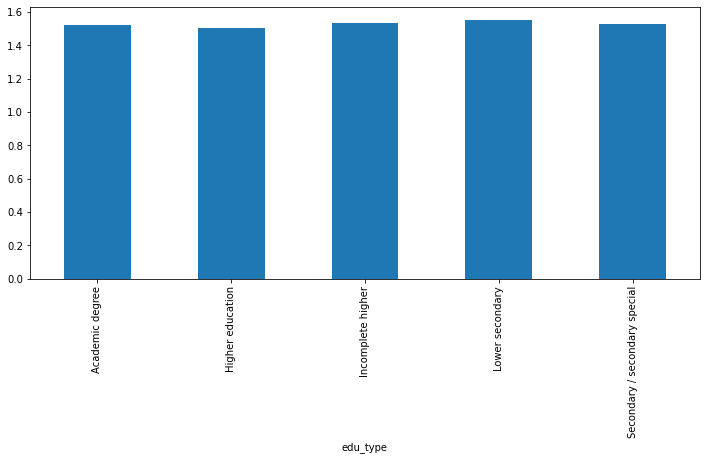

In [22]:
train.groupby('edu_type')['credit'].mean().plot(kind='bar', figsize=(12,5))

8. family_type

In [23]:
train['family_type'].value_counts()

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64

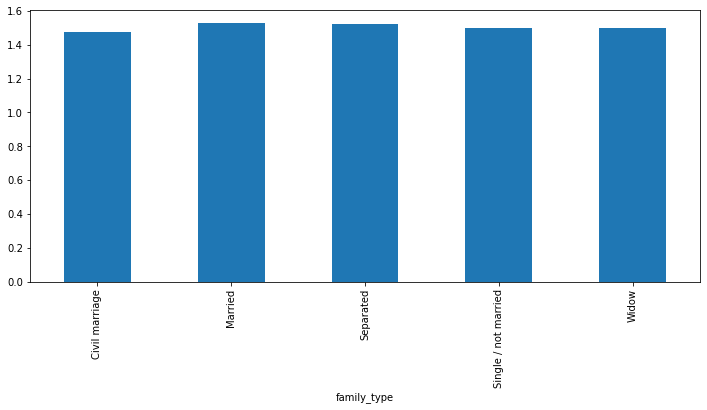

In [24]:
train.groupby('family_type')['credit'].mean().plot(kind='bar', figsize=(12,5))

9. house_type

In [25]:
train['house_type'].value_counts()

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

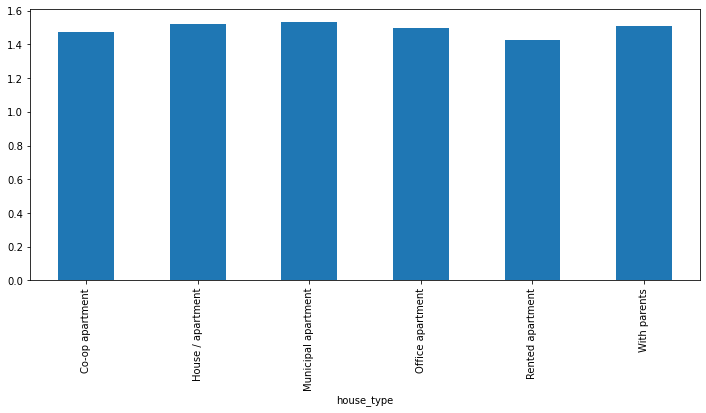

In [26]:
train.groupby('house_type')['credit'].mean().plot(kind='bar', figsize=(12,5))

10. DAYS_BIRTH

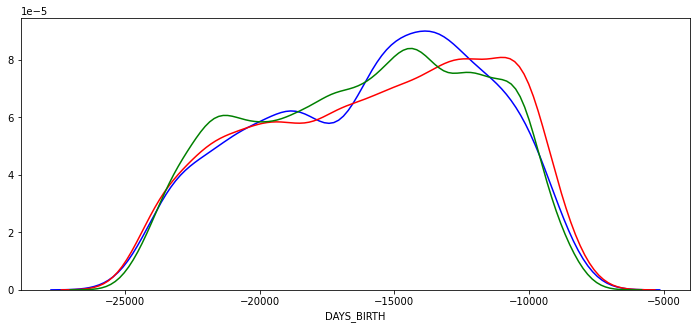

In [27]:
df1 = train.loc[train['credit']==0, 'DAYS_BIRTH']
df2 = train.loc[train['credit']==1, 'DAYS_BIRTH']
df3 = train.loc[train['credit']==2, 'DAYS_BIRTH']

plt.figure(figsize = (12,5))
sns.distplot(df1, kde=True, rug=False, hist=False, color = 'blue')
sns.distplot(df2, kde=True, rug=False, hist=False, color = 'red')
sns.distplot(df3, kde=True, rug=False, hist=False, color = 'green')

11. DAYS_EMPLOYED

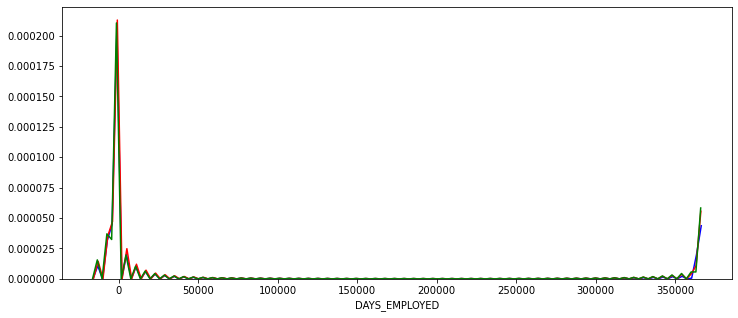

In [28]:
df1 = train.loc[train['credit']==0, 'DAYS_EMPLOYED']
df2 = train.loc[train['credit']==1, 'DAYS_EMPLOYED']
df3 = train.loc[train['credit']==2, 'DAYS_EMPLOYED']

plt.figure(figsize = (12,5))
sns.distplot(df1, kde=True, rug=False, hist=False, color = 'blue')
sns.distplot(df2, kde=True, rug=False, hist=False, color = 'red')
sns.distplot(df3, kde=True, rug=False, hist=False, color = 'green')

12. FLAG_MOBIL

In [29]:
train['FLAG_MOBIL'].value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

13. work_phone

In [30]:
train['work_phone'].value_counts()

0    20511
1     5946
Name: work_phone, dtype: int64

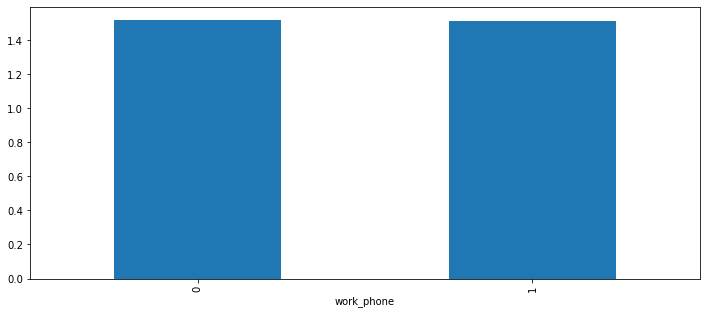

In [31]:
train.groupby('work_phone')['credit'].mean().plot(kind='bar', figsize=(12,5))

14. phone

In [32]:
train['phone'].value_counts()

0    18672
1     7785
Name: phone, dtype: int64

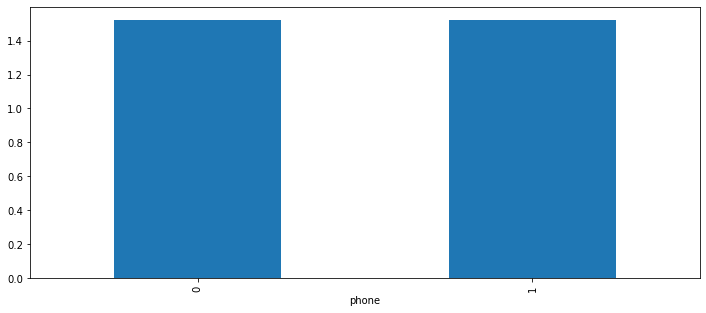

In [33]:
train.groupby('phone')['credit'].mean().plot(kind='bar', figsize=(12,5))

15. email

In [34]:
train['email'].value_counts()

0    24042
1     2415
Name: email, dtype: int64

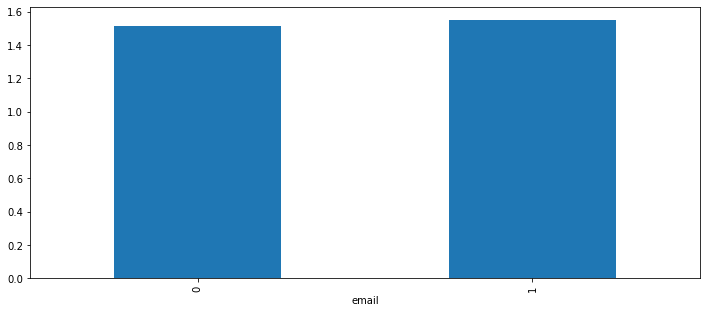

In [35]:
train.groupby('email')['credit'].mean().plot(kind='bar', figsize=(12,5))

16. occyp_type

In [36]:
train['occyp_type'].value_counts()

NAN                      8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

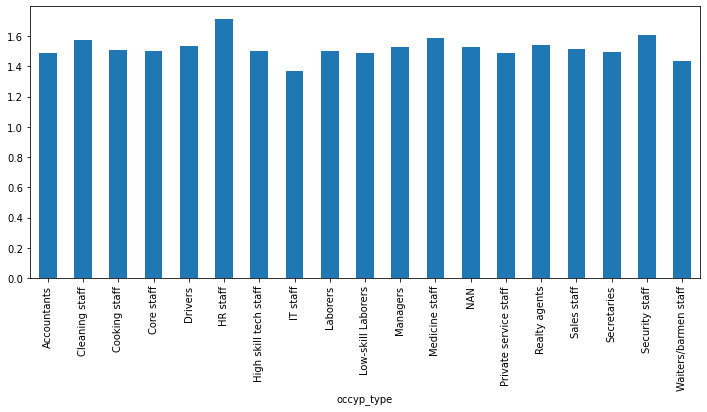

In [37]:
train.groupby('occyp_type')['credit'].mean().plot(kind='bar', figsize=(12,5))

17. family_size

In [38]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

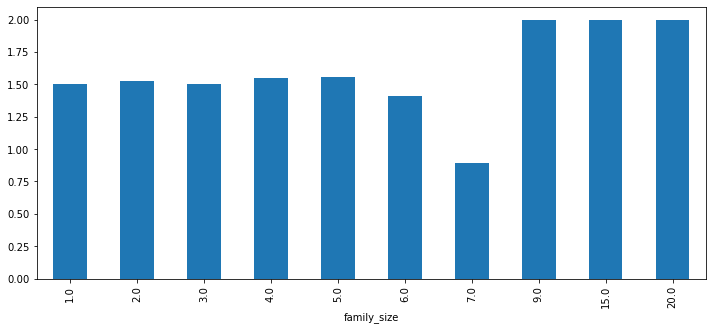

In [39]:
train.groupby('family_size')['credit'].mean().plot(kind='bar', figsize=(12,5))

18. begin_month

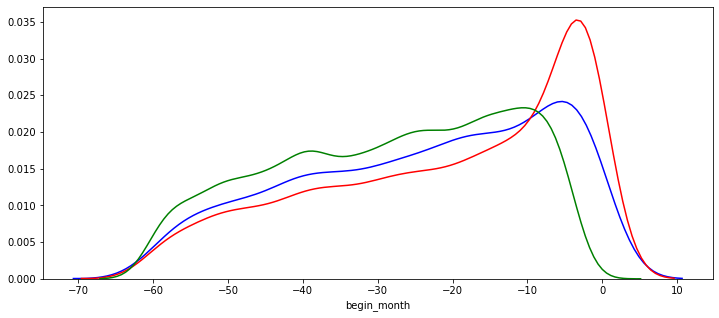

In [40]:
df1 = train.loc[train['credit']==0, 'begin_month']
df2 = train.loc[train['credit']==1, 'begin_month']
df3 = train.loc[train['credit']==2, 'begin_month']

plt.figure(figsize = (12,5))
sns.distplot(df1, kde=True, rug=False, hist=False, color = 'blue')
sns.distplot(df2, kde=True, rug=False, hist=False, color = 'red')
sns.distplot(df3, kde=True, rug=False, hist=False, color = 'green')

19. credit

In [41]:
train['credit'].value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

## Feature Engineering

### family_size & child_num 문제

In [42]:
train[train['family_size'] ==7]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
2671,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-11.0,2.0
9615,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-19.0,1.0
10321,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-46.0,0.0
12876,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-15.0,1.0
17560,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-20.0,1.0
17978,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-21.0,1.0
19792,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-59.0,0.0
20117,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-21.0,1.0
22592,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-10.0,1.0


In [43]:
train[train['family_size'] == 9]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
25313,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13827,-1649,1,1,1,0,Cleaning staff,9.0,-26.0,2.0
25638,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13827,-1649,1,1,1,0,Cleaning staff,9.0,-31.0,2.0


In [44]:
train[train['family_size'] == 15]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
8462,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,-7.0,2.0
9021,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,-58.0,2.0
25390,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,-43.0,2.0


In [45]:
train[train['family_size'] == 20]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-11057,-1853,1,1,1,0,Waiters/barmen staff,20.0,-5.0,2.0


위와 같은 레이블들이 family_size에 이상치라고 생각되는 레이블들
chile_num과 family_type을 통해 family_size를 계산해본 결과 이상없음

해결방법
0. 그냥 넣기
1. drop
2. 평균값 대치 -> child_num도 대치해야할듯

## model

In [46]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

In [47]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [48]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [50]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.649825	valid_1's multi_logloss: 0.754342
[200]	training's multi_logloss: 0.565196	valid_1's multi_logloss: 0.738368
[300]	training's multi_logloss: 0.503465	valid_1's multi_logloss: 0.731678
Early stopping, best iteration is:
[307]	training's multi_logloss: 0.499573	valid_1's multi_logloss: 0.731416


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.646021	valid_1's multi_logloss: 0.764365
[200]	training's multi_logloss: 0.560632	valid_1's multi_logloss: 0.751211
[300]	training's multi_logloss: 0.497513	valid_1's multi_logloss: 0.748437
Early stopping, best iteration is:
[330]	training's multi_logloss: 0.480923	valid_1's multi_logloss: 0.747248


====================================3===

In [51]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [53]:
submit.to_csv('C:/Users/hym97/신용카드/20210511_baseline.csv', index=False) # 0.7272812144